<a href="https://colab.research.google.com/github/Ramprabu95/AI_based_image_compression/blob/main/rcnn_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda')
class RCNN(nn.Module):
    """
    Recurrent Convolutional Neural Networks for Text Classification (2015)
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, hidden_size_linear, class_num, dropout):
        super(RCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True, dropout=dropout)
        self.W = nn.Linear(embedding_dim + 2*hidden_size, hidden_size_linear)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(hidden_size_linear, class_num)

    def forward(self, x):
        # x = |bs, seq_len|
        x_emb = self.embedding(x)
        # x_emb = |bs, seq_len, embedding_dim|
        output, _ = self.lstm(x_emb)
        # output = |bs, seq_len, 2*hidden_size|
        output = torch.cat([output, x_emb], 2)
        # output = |bs, seq_len, embedding_dim + 2*hidden_size|
        output = self.tanh(self.W(output)).transpose(1, 2)
        # output = |bs, seq_len, hidden_size_linear| -> |bs, hidden_size_linear, seq_len|
        output = F.max_pool1d(output, output.size(2)).squeeze(2)
        # output = |bs, hidden_size_linear|
        output = self.fc(output)
        # output = |bs, class_num|
        return output

In [2]:

import torch
from torch.utils.data import Dataset


class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, dictionary):
        # Unknown Token is index 1 (<UNK>)
        self.x = [[dictionary.get(token, 1) for token in token_list] for token_list in texts]
        self.y = labels

    def __len__(self):
        """Return the data length"""
        return len(self.x)

    def __getitem__(self, idx):
        """Return one item on the index"""
        return self.x[idx], self.y[idx]


def collate_fn(data, max_len, pad_idx=0):
    """Padding"""
    texts, labels = zip(*data)
    texts = [s + [pad_idx] * (max_len - len(s)) if len(s) < max_len else s[:max_len] for s in texts]
    return torch.LongTensor(texts), torch.LongTensor(labels)

In [3]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
nltk.download('punkt')


def read_file(file_path):
    """
    Read function for AG NEWS Dataset
    """
    data = pd.read_csv(file_path, names=["class", "title", "description"])
    texts = list(data['title'].values + ' ' + data['description'].values)
    texts = [word_tokenize(preprocess_text(sentence)) for sentence in texts]
    labels = [label-1 for label in list(data['class'].values)]  # label : 1~4  -> label : 0~3
    return texts, labels


def preprocess_text(string):
    """
    reference : https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = string.lower()
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()


def metrics(dataloader, losses, correct, y_hats, targets):
    avg_loss = losses / len(dataloader)
    accuracy = correct / len(dataloader.dataset) * 100
    precision = precision_score(targets, y_hats, average='macro')
    recall = recall_score(targets, y_hats, average='macro')
    f1 = f1_score(targets, y_hats, average='macro')
    cm = confusion_matrix(targets, y_hats)
    return avg_loss, accuracy, precision, recall, f1, cm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:

import os
import logging
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



def train(model, optimizer1,optimizer2, train_dataloader, valid_dataloader, epochs):
    best_f1 = 0
    loss_val=[]
    step_num=[]
    count = 1
    print('Start Training!')
    for epoch in range(1, epochs+1):
        model.train()
        for step, (x, y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            if loss>0.3:
              optimizer1.zero_grad()
              loss.backward()
              optimizer1.step()
            else:
              optimizer2.zero_grad()
              loss.backward()
              optimizer2.step()

            if (step+1) % 200 == 0:
                print(f'|EPOCHS| {epoch:>}/{epochs} |STEP| {step+1:>4}/{len(train_dataloader)} |LOSS| {loss.item():>.4f}')
                loss_val.append(loss.item())
                step_num.append(int(count))
                count += 1
        avg_loss, accuracy, _, _, f1, _ = evaluate(model, valid_dataloader)
        print('-'*50)
        print(f'|* VALID SET *| |VAL LOSS| {avg_loss:>.4f} |ACC| {accuracy:>.4f} |F1| {f1:>.4f}')
        print('-'*50)
        PATH = './best.pth'
        if f1 > best_f1:
            best_f1 = f1
            print(f'Saving best model... F1 score is {best_f1:>.4f}')
            torch.save(model.state_dict(),PATH)
            print('Model saved!')
    plt.plot(step_num,loss_val)
    plt.xlabel("Step Number")
    plt.ylabel("Loss")
    plt.show()


def evaluate(model, valid_dataloader):
    with torch.no_grad():
        model.eval()
        losses, correct = 0, 0
        y_hats, targets = [], []
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            losses += loss.item()

            y_hat = torch.max(pred, 1)[1]
            y_hats += y_hat.tolist()
            targets += y.tolist()
            correct += (y_hat == y).sum().item()

    avg_loss, accuracy, precision, recall, f1, cm = metrics(valid_dataloader, losses, correct, y_hats, targets)
    return avg_loss, accuracy, precision, recall, f1, cm



In [5]:
from collections import Counter


def build_dictionary(texts, vocab_size):
    counter = Counter()
    SPECIAL_TOKENS = ['<PAD>', '<UNK>']

    for word in texts:
        counter.update(word)

    words = [word for word, count in counter.most_common(vocab_size - len(SPECIAL_TOKENS))]
    words = SPECIAL_TOKENS + words
    word2idx = {word: idx for idx, word in enumerate(words)}

    return word2idx

In [6]:
from google.colab import drive 

# Mounting google drive
drive.mount('/content/drive')

Mounted at /content/drive


Start Training!
|EPOCHS| 1/10 |STEP|  200/1719 |LOSS| 1.2168
|EPOCHS| 1/10 |STEP|  400/1719 |LOSS| 1.0935
|EPOCHS| 1/10 |STEP|  600/1719 |LOSS| 0.7955
|EPOCHS| 1/10 |STEP|  800/1719 |LOSS| 0.6004
|EPOCHS| 1/10 |STEP| 1000/1719 |LOSS| 0.6215
|EPOCHS| 1/10 |STEP| 1200/1719 |LOSS| 0.5253
|EPOCHS| 1/10 |STEP| 1400/1719 |LOSS| 0.3879
|EPOCHS| 1/10 |STEP| 1600/1719 |LOSS| 0.3410
--------------------------------------------------
|* VALID SET *| |VAL LOSS| 0.4598 |ACC| 83.7900 |F1| 0.8370
--------------------------------------------------
Saving best model... F1 score is 0.8370
Model saved!
|EPOCHS| 2/10 |STEP|  200/1719 |LOSS| 0.3219
|EPOCHS| 2/10 |STEP|  400/1719 |LOSS| 0.4163
|EPOCHS| 2/10 |STEP|  600/1719 |LOSS| 0.5028
|EPOCHS| 2/10 |STEP|  800/1719 |LOSS| 0.3301
|EPOCHS| 2/10 |STEP| 1000/1719 |LOSS| 0.2900
|EPOCHS| 2/10 |STEP| 1200/1719 |LOSS| 0.5308
|EPOCHS| 2/10 |STEP| 1400/1719 |LOSS| 0.4041
|EPOCHS| 2/10 |STEP| 1600/1719 |LOSS| 0.3676
-------------------------------------------------

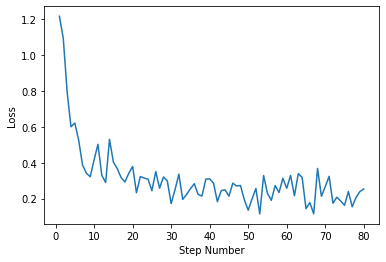

In [8]:
train_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/train.csv'
import os
import argparse
import logging
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

model = RCNN(vocab_size=8000,
            embedding_dim=300,
            hidden_size=512,
            hidden_size_linear=512,
            class_num=4,
            dropout=0.0).to(device)


train_texts, train_labels = read_file(train_file_path)
word2idx = build_dictionary(train_texts, vocab_size=8000)
full_dataset = CustomTextDataset(train_texts, train_labels, word2idx)
num_train_data = len(full_dataset) - 10000
train_dataset, val_dataset = random_split(full_dataset, [num_train_data, 10000])
train_dataloader = DataLoader(dataset=train_dataset,
                                  collate_fn=lambda x: collate_fn(x, 64),
                                  batch_size=64,
                                  shuffle=True)

valid_dataloader = DataLoader(dataset=val_dataset,
                                  collate_fn=lambda x: collate_fn(x, 64),
                                  batch_size=64,
                                  shuffle=True)

optimizer1 = torch.optim.Adam(model.parameters(), lr=3e-5)
optimizer2 = torch.optim.Adam(model.parameters(), lr=3e-6)
train(model, optimizer1,optimizer2, train_dataloader, valid_dataloader,10)

In [9]:
test_model = RCNN(vocab_size=8000,
            embedding_dim=300,
            hidden_size=512,
            hidden_size_linear=512,
            class_num=4,
            dropout=0.0).to(device)
PATH = './best.pth'
test_model.load_state_dict(torch.load(PATH))



<All keys matched successfully>

In [10]:
test_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/test.csv'
test_texts, test_labels = read_file(test_file_path)
test_dataset = CustomTextDataset(test_texts, test_labels, word2idx)
test_dataloader = DataLoader(dataset=test_dataset,
                            collate_fn=lambda x: collate_fn(x, 64),
                            batch_size=64,
                            shuffle=True)

_, accuracy, precision, recall, f1, cm = evaluate(test_model, test_dataloader)
print('-'*50)
print(f'|* TEST SET *| |ACC| {accuracy:>.4f} |PRECISION| {precision:>.4f} |RECALL| {recall:>.4f} |F1| {f1:>.4f}')
print('-'*50)
print('---------------- CONFUSION MATRIX ----------------')
for i in range(len(cm)):
  print(cm[i])
print('--------------------------------------------------')


--------------------------------------------------
|* TEST SET *| |ACC| 90.1711 |PRECISION| 0.9020 |RECALL| 0.9017 |F1| 0.9018
--------------------------------------------------
---------------- CONFUSION MATRIX ----------------
[1720   46   74   60]
[  42 1806   20   32]
[  74   11 1639  176]
[  59   21  132 1688]
--------------------------------------------------
